## Dataloaders for radiology datasets 

In [31]:
import os
import numpy as np
from radvlm.data.utils import custom_collate_fn
from torch.utils.data import DataLoader
from radvlm.data.create_instructions import format_boxes
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Let's first create a function to display images with potentially some BBox. 

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_img(array_data, boxes=None):
    # Display the image
    fig, ax = plt.subplots()
    ax.imshow(array_data[0], cmap='gray')
    
    # Get image dimensions
    img_height, img_width = array_data[0].shape

    # Draw bounding boxes if provided
    if boxes:
        for box in boxes:
            # Convert proportional coordinates to pixel coordinates
            x1, y1, x2, y2 = box
            x1_pixel = x1 * img_width
            y1_pixel = y1 * img_height
            x2_pixel = x2 * img_width
            y2_pixel = y2 * img_height
            
            # Calculate width and height of the bounding box
            width = x2_pixel - x1_pixel
            height = y2_pixel - y1_pixel
            
            # Create a rectangle patch
            rect = patches.Rectangle((x1_pixel, y1_pixel), width, height, linewidth=3, edgecolor='r', facecolor='none')
            
            # Add the rectangle to the plot
            ax.add_patch(rect)

    # Optional: Add colorbar and show the plot
    plt.colorbar(ax.imshow(array_data[0], cmap='gray'), ax=ax)
    plt.show()

def display_instruction(instruction):
    return print(json.dumps(instruction, indent=4, ensure_ascii=False))

Now let's retrieve the env variable `DATA_DIR`, to indicate where all datasets are located

In [3]:
from radvlm import DATA_DIR

### MIMIC-CXR dataset - Report generation

In [4]:
from radvlm.data.datasets import MIMIC_Dataset_MM

datasetpath = os.path.join(DATA_DIR, 'MIMIC-CXR-JPG')
filtered_reports_dir = os.path.join(datasetpath, 'filtered_reports') # if you have the filtered reports dir
conversation_dir =  os.path.join(datasetpath, 'conversations/train/standard') # if present 

dataset = MIMIC_Dataset_MM(
    datasetpath=datasetpath,
    split='train',
    flag_img=True, # set to True if you want the get_item function to get the images
    flag_lab=True, #  # set to True if you want the get_item function to get the labels
    flag_instr=True, # set to True to create instructions for report generation
    only_frontal=True, # set to True to ignore lateral images
    filtered_reports_dir=filtered_reports_dir, # will show filtered reports. Set to None for original reports
    sentencesBBoxpath=None, # indicate if you want to keep only the subset of samples from MS-CXR 
    conversation_dir=None, # indicate if you want to keep only the subset of samples that have conversations
)

print(len(dataset))

230980


Now we can create a dataloader from the dataset. 

In [8]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn )   

Let's explore some samples with images and attributes. If you want a new sample, simply reload the cell


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/MIMIC-CXR-JPG/files/p16/p16724018/s52211132/841168c1-cd886c23-a3f52a26-b784ba6b-b818911f.jpg

--------- Image ---------


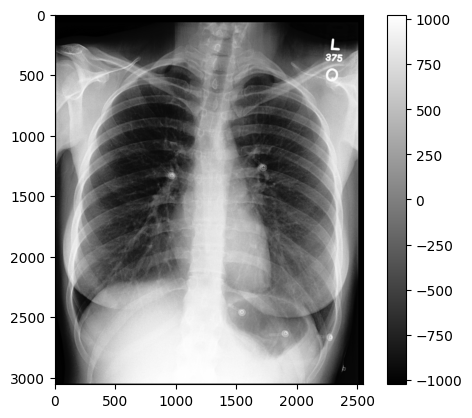


--------- Report ---------
The cardiac, mediastinal and hilar contours are normal. Both lungs are clear with no focal consolidation, pleural effusion or pneumothorax.

--------- Labels ---------
[]

--------- RG Instructions ---------
{
    "question": "Please give a detailed radiology report from this Chest X-Ray image.",
    "answer": "The cardiac, mediastinal and hilar contours are normal. Both lungs are clear with no focal consolidation, pleural effusion or pneumothorax."
}

--------- Conversation ---------
[
    {
        "from": "human",
        "value": "Can you tell me the view of the chest X-ray?"
    },
    {
        "from": "gpt",
        "value": "The X-ray is taken in the PA (posteroanterior) view."
    },
    {
        "from": "human",
        "value": "Does the X-ray show any abnormalities?"
    },
    {
        "from": "gpt",
        "value": "The X-ray does not show any identifiable abnormalities."
    },
    {
        "from": "human",
        "value": "What about the

In [ ]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Image ---------")
show_img(sample[0]["img"])

print("\n--------- Report ---------")
print(sample[0]["txt"])

print("\n--------- Labels ---------")
print(sample[0]["labels"])

print("\n--------- RG Instructions ---------")
display_instruction(sample[0]["instr"])

#if you added conversation dir in the arguments 
# print("\n--------- Conversation ---------")
# display_instruction(sample[0]["conversation"])



### MS-CXR - Phrase Grounding
This class is derived from MIMIC-CXR, and bring the grounded phrases. It is organized per phrase (different datapoints can have same image)

In [33]:
from radvlm.data.datasets import MS_CXR

datasetpath_mimic = os.path.join(DATA_DIR, 'MIMIC-CXR-JPG') # we need this to get the images as it is derived from MIMIC-CXR
sentencesBBoxpath = os.path.join(DATA_DIR, 'MS-CXR','sentences_and_BBox_mscxr')
dataset = MS_CXR(
    datasetpath = datasetpath_mimic,
    split="train", 
    flag_img=True, 
    flag_lab=True, 
    only_frontal=True, 
    flag_instr=True, 
    sentencesBBoxpath=sentencesBBoxpath,
    seed=0)
print(len(dataset))

964


In [34]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn )   


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/MIMIC-CXR-JPG/files/p19/p19879454/s52698197/41ad325a-6d408609-7c59fc9e-b3cda836-8c530739.jpg

--------- Phrase ---------
enlarged cardiac silhouette

--------- Bounding box ---------
[0.32, 0.41, 0.91, 0.83]

--------- Image ---------


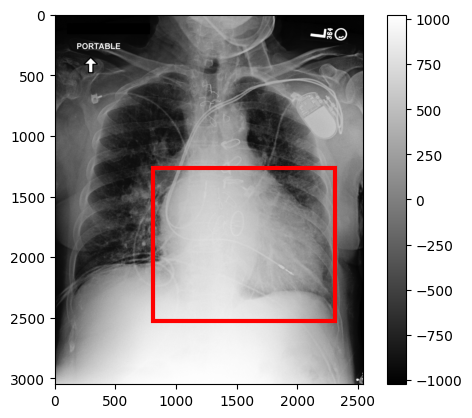


--------- Phrase grounding Instruction ---------
{
    "question": "Please indicate where this finding is located: enlarged cardiac silhouette",
    "answer": "It is displayed at [0.32, 0.41, 0.91, 0.83] in the radiograph."
}


In [35]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Phrase ---------")
print(sample[0]["label"])

print("\n--------- Bounding box ---------")
print(format_boxes(sample[0]["boxes"]))

print("\n--------- Image ---------")
show_img(sample[0]["img"], sample[0]["boxes"])

print("\n--------- Phrase grounding Instruction ---------")
display_instruction(sample[0]["instr"])

### Chest ImaGenome dataset - Anatomical grounding

In [7]:
from radvlm.data.datasets import Chest_ImaGenome_Dataset

datasetpath_mimic = os.path.join(DATA_DIR, 'MIMIC-CXR-JPG') # we need this to get the images
datasetpath_chestima = os.path.join(DATA_DIR, 'CHEST_IMA')
filtered_reports_dir = os.path.join(datasetpath_mimic, 'filtered_reports') # if you have the filtered reports dir

split = "train"
dataset = Chest_ImaGenome_Dataset(
    datasetpath=datasetpath_mimic,
    datasetpath_chestima=datasetpath_chestima, 
    split=split, 
    filtered_reports_dir=None, # optional, if you want filtered reports llm-generated
    flag_img=True, 
    flag_instr=True, 
    flag_txt=True, 
    flag_lab=False,
    pick_one_region=True, # if you want just one (randomly picked) region to be retrieved in the get_item. Set to False to if you want them all 
    sentencesBBoxpath=None,
    )

print(len(dataset))

162794


In [8]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn)  


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/MIMIC-CXR-JPG/files/p14/p14614003/s59990168/932372e4-8e8015f0-0fc9da50-6df053a9-79e6b655.jpg

--------- Report ---------
No pneumothorax.

--------- Region name ---------
left upper lung zone

--------- Bounding box ---------
[0.54, 0.09, 0.8, 0.39]

--------- Image ---------


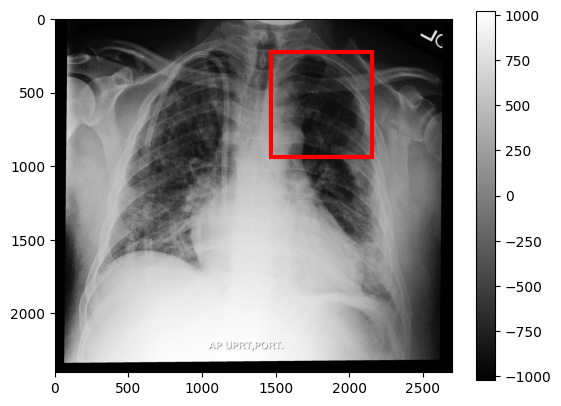


--------- Anatomy grounding Instructions ---------
{
    "question": "Can you point out the left upper lung zone's position on the image?",
    "answer": "The left upper lung zone is located at the coordinates [0.54, 0.09, 0.8, 0.39] on the image."
}


In [9]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Report ---------")
print(sample[0]["txt"])

print("\n--------- Region name ---------")
print(sample[0]["label"])

print("\n--------- Bounding box ---------")
print(format_boxes(sample[0]["boxes"])) # formating to round to 2 floating point numbers, just for display purposes

print("\n--------- Image ---------")
show_img(sample[0]["img"], sample[0]["boxes"])

print("\n--------- Anatomy grounding Instructions ---------")
display_instruction(sample[0]["instr"])

### VinDr-CXR dataset - Abnormality detection
This dataset class is designed for abnormality detection: it contains all samples from the original VinDr-CXR (healthy and non healthy), and displays instructions for abnormliaty detection task.

In [36]:
from radvlm.data.datasets import VinDr_CXR_Dataset

datasetpath = os.path.join(DATA_DIR, "VinDr-CXR") 

dataset = VinDr_CXR_Dataset(
    datasetpath=datasetpath, 
    split="train", 
    flag_img=True, 
    flag_instr=True,
    )

print(len(dataset))

15000


In [37]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn, num_workers=1)


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/VinDr-CXR/train_jpg/8963fbcc7705cb98857ef46075d00326.jpg

--------- Abnormality names ---------
['No finding']

--------- Bounding box ---------
[]

--------- Image ---------


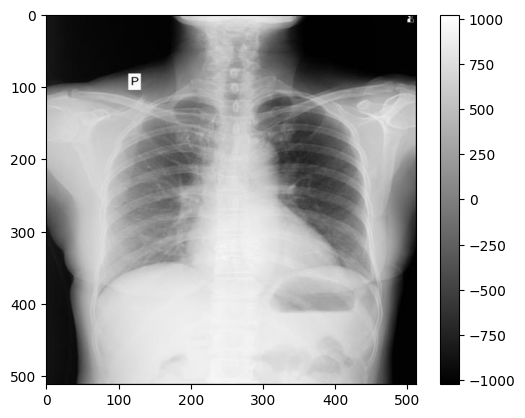


--------- Abnormality detection instruction ---------
{
    "question": "Are there identifiable abnormalities on this Chest X-ray? If so, where are they located?",
    "answer": "This Chest X-ray shows no signs of abnormalities or lesions."
}


In [38]:
sample = next(iter(data_loader))


print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Abnormality names ---------")
print(sample[0]["labels"])

print("\n--------- Bounding box ---------")
print(sample[0]["boxes"])

print("\n--------- Image ---------")
show_img(sample[0]["img"], sample[0]["boxes"])

print("\n--------- Abnormality detection instruction ---------")
display_instruction(sample[0]["instr"])

### VinDr-CXR for mono-class grounding
This class is designed for abnormality grounding: there are no healthy samples, only samples that contain abnormality; plus, there is only one abnormality per sample. 

In [39]:
from radvlm.data.datasets import VinDr_CXR_Single_Label_Dataset


datasetpath = os.path.join(DATA_DIR, "VinDr-CXR") 

dataset = VinDr_CXR_Single_Label_Dataset(
    datasetpath=datasetpath, 
    split="train", 
    flag_img=True, 
    flag_instr=True,
    )

print(len(dataset))

16089


In [40]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn, num_workers=1)


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/VinDr-CXR/train_jpg/0c2079e62ddfb06a8a5300cefaa3a970.jpg

--------- Abnormality name ---------
Lung Opacity

--------- Bounding box ---------
[0.2, 0.56, 0.26, 0.6] and [0.78, 0.69, 0.82, 0.71]

--------- Image ---------


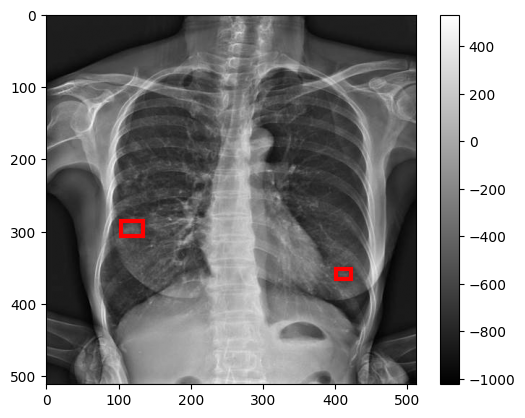


--------- Abnormality grounding instruction} ---------
{
    "question": "Where on this image is the lung opacity located?",
    "answer": "In the X-ray, the lung opacity is identifiable at [0.2, 0.56, 0.26, 0.6] and [0.78, 0.69, 0.82, 0.71]."
}


In [17]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Abnormality name ---------")
print(sample[0]["label"])

print("\n--------- Bounding box ---------")
print(format_boxes(sample[0]["boxes"]))

print("\n--------- Image ---------")
show_img(sample[0]["img"], sample[0]["boxes"])

print("\n--------- Abnormality grounding instruction} ---------")
display_instruction(sample[0]["instr"])

### CheXpert Dataset - abnormality classification

In [18]:
from radvlm.data.datasets import CheXpert_Dataset_MM

datasetpath = os.path.join(DATA_DIR, 'CheXpert')
dataset = CheXpert_Dataset_MM(
    datasetpath=datasetpath,
    split='train',
    unique_patients=False, 
    only_frontal=True, 
    flag_img=True,
    flag_instr=True,
    flag_lab=True,
)
print(len(dataset))

191027


In [19]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn, num_workers=1)


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/CheXpert/train/patient35525/study5/view1_frontal.jpg

--------- Image ---------


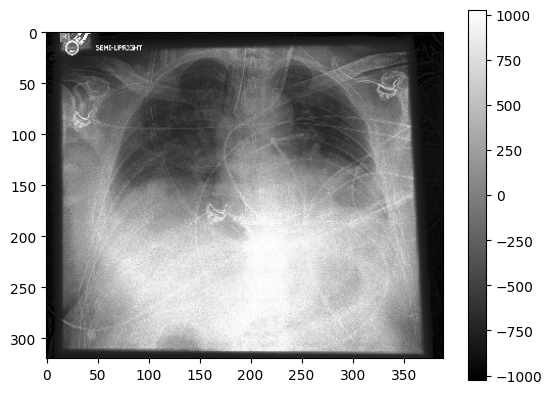


--------- Abnormality labels ---------
['Atelectasis', 'Consolidation', 'Lung Opacity', 'Support Devices']

--------- Abnormality classification instruction} ---------
{
    "question": "Tell me about abnormalities on this image",
    "answer": "The analysis reveals these abnormalities: atelectasis, consolidation, lung opacity and support devices."
}


In [20]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Image ---------")
show_img(sample[0]["img"])

print("\n--------- Abnormality labels ---------")
print(sample[0]["labels"])

print("\n--------- Abnormality classification instruction} ---------")
display_instruction(sample[0]["instr"])

### CheXpert-Plus - report generation 


In [21]:
from radvlm.data.datasets import CheXpertPlus_Dataset

datasetpath = os.path.join(DATA_DIR, 'CheXpert')
filtered_reports_dir = os.path.join(datasetpath, 'filtered_reports')
dataset = CheXpertPlus_Dataset(
    datasetpath=datasetpath, 
    split='train',
    flag_img=True,
    flag_txt=True, 
    flag_lab=True,
    only_frontal=True, 
    filtered_reports_dir=filtered_reports_dir, # optional, set to None for original reports
)
print(len(dataset))

186463


In [22]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn, num_workers=1)


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/CheXpert/train/patient39795/study3/view1_frontal.jpg

--------- Image ---------


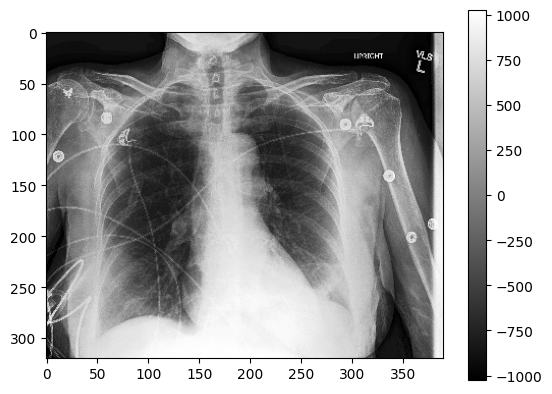


--------- Report ---------
Small bilateral pleural effusions. No pulmonary edema.

--------- Labels ---------
['Lung Opacity', 'Pneumothorax', 'Support Devices']

--------- RG Instructions ---------
{
    "question": "Analyze the Chest X-Ray and report your findings.",
    "answer": "Small bilateral pleural effusions. No pulmonary edema."
}


In [23]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Image ---------")
show_img(sample[0]["img"])

print("\n--------- Report ---------")
print(sample[0]["txt"])

print("\n--------- Labels ---------")
print(sample[0]["labels"])

print("\n--------- RG Instructions ---------")
display_instruction(sample[0]["instr"])

### PadChest - Phrase grounding
This dataset class is organized per observations, i.e., different datapoints can contain the same image (like for VinDr-CXR mono class)

In [24]:
from radvlm.data.datasets import PadChest_grounding

datasetpath = os.path.join(DATA_DIR, 'PadChest')
dataset = PadChest_grounding(
    datasetpath=datasetpath,
    split='train',
    flag_instr=True,
    flag_img=True
)



In [25]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn, num_workers=1)

In [26]:
sample = next(iter(data_loader))


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/PadChest/images_grounding/231779677090102348217464859449304617573_2_r7251i.png

--------- Image ---------


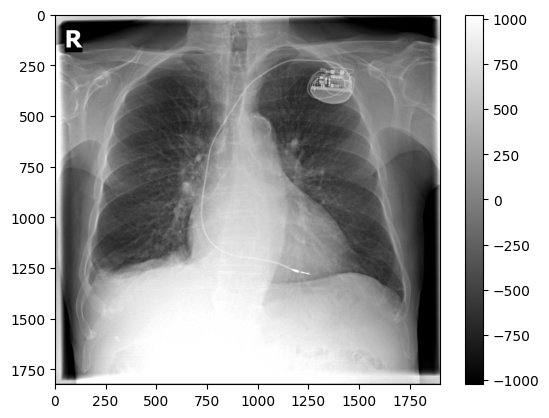


--------- Report ---------
 indic cardiotorac limit . calcificacion cay . hili prominent caract vascul . pequen atelectasi subsegmentari bas derech . marcapas unicameral .

--------- Phrase ---------
Calcification of the aortic arch.

--------- RG Instructions ---------
{
    "question": "Please show me the location of: calcification of the aortic arch.",
    "answer": "This finding is located at [0.49, 0.27, 0.59, 0.36] in the image."
}


In [27]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Image ---------")
show_img(sample[0]["img"])

print("\n--------- Report ---------")
print(sample[0]["txt"])

print("\n--------- Phrase ---------")
print(sample[0]["label"])

print("\n--------- RG Instructions ---------")
display_instruction(sample[0]["instr"])

If you want to load the dataset per image with conversations, use the other class (below)

In [28]:
from radvlm.data.datasets import PadChest_grounding_per_image

conversation_dir = os.path.join(datasetpath, 'conversations/train/grounding')

dataset = PadChest_grounding_per_image(
    datasetpath=datasetpath,
    split='train',
    flag_img=True, 
    conversation_dir=conversation_dir
)
print(len(dataset))

1945


In [29]:
data_loader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn, num_workers=1)


--------- Image Path ---------
/cluster/dataset/medinfmk/public_radiology_repo/PadChest/images_grounding/283805181589880543166636795920901745413_nsc06r.png

--------- Image ---------


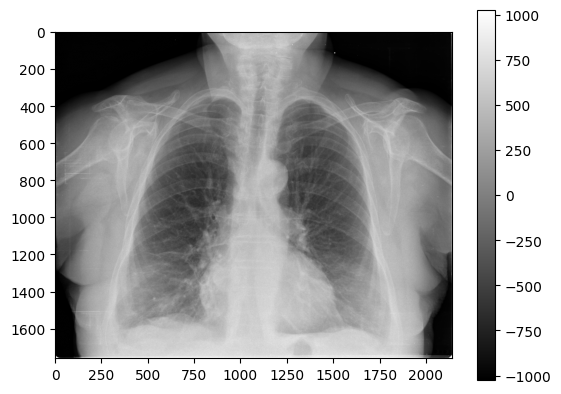


--------- Report ---------
 sign radiolog epoc . pinzamient sen costofren derech . no apreci infiltr condens parenquimat pulmonar .

--------- Phrases ---------
[
    {
        "observation": "Blunting of the right costophrenic angle.",
        "box": [
            0.09438648782911079,
            0.8043478260869565,
            0.23149528067560854,
            0.9728260869565217
        ]
    }
]

--------- Grounded conversations ---------
[
    {
        "from": "human",
        "value": "Can you tell me what you see in this chest X-ray?"
    },
    {
        "from": "gpt",
        "value": "Certainly. In this chest X-ray, I notice a blunting of the right costophrenic angle, which is a point where the diaphragm meets the ribs at the bottom of the lung on the right side."
    },
    {
        "from": "human",
        "value": "What does it mean when the costophrenic angle is blunted?"
    },
    {
        "from": "gpt",
        "value": "Blunting of the costophrenic angle can suggest

In [30]:
sample = next(iter(data_loader))

print("\n--------- Image Path ---------")
print(sample[0]["img_path"])

print("\n--------- Image ---------")
show_img(sample[0]["img"])

print("\n--------- Report ---------")
print(sample[0]["txt"])

print("\n--------- Phrases ---------")
display_instruction(sample[0]["sentencesBBox"])

print("\n--------- Grounded conversations ---------")
display_instruction(sample[0]["conversation"])